<a href="https://colab.research.google.com/github/abhilb/DicomImageClassification/blob/main/Build_a_VGG16_Model_Milestone_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning for Dicom Image Classification

# Workflow

1. Load the XRAY image dataset, define paths to the datasets, including path to COVID and Non-COVID data.

2. Open and display a random set of 9 images (COVID and non-COVID) from the XRAY image dataset.

3. Resize all images to 224x224 pixels.

4. Plot label distribution of images- that is how many images per label for XRAY image dataset.

5. Estimate image statistics- mean, max, min, standard deviation of pixel values in X-ray images.

6. Plot histogram of image intensities for COVID and Non-COVID images from the XRAY image dataset.

7. Compare histograms of COVID and Non-COVID images. How do they differ? What information do you get from the histograms?

8. Convert all images from the COVID and Non-COVID directories in DICOM (.dcm) format.

9. Save all file paths with their class labels to a CSV file.

In [3]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import random
import pandas as pd
from itertools import chain
from collections import defaultdict

## Step 1. Load the XRAY image dataset, define paths to the datasets, including path to COVID and NON-COVID data.

In [ ]:
!unzip '/content/gdrive/MyDrive/Colab Notebooks/content/COVID-19_Radiography_Database.zip'

In [13]:
NORMAL_IMAGES_PATH = Path('COVID-19_Radiography_Dataset/Normal/')
COVID_IMAGES_PATH = Path('COVID-19_Radiography_Dataset/COVID/')

In [28]:
dataset = defaultdict(list)
for img_name in chain(NORMAL_IMAGES_PATH.rglob('*.png'), COVID_IMAGES_PATH.rglob('*.png')):
  label = img_name.parent.stem.upper()
  fname = img_name
  dataset['label'].append(label)
  dataset['path'].append(fname)
df = pd.DataFrame(dataset)

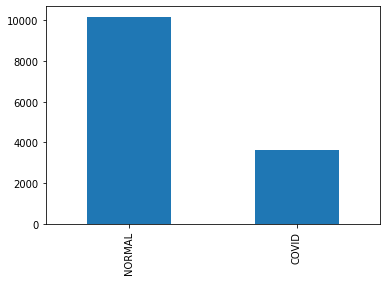

In [29]:
df['label'].value_counts().plot(kind='bar')
plt.show()